# Project 7: Implement a scoring model.

*Pierre-Eloi Ragetly*

This project is part of the Data Scientist path proposed by OpenClassrooms.

In [1]:
# File system management
import os

# Get execution time to compare models
import time

# Import numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams.update({'axes.edgecolor': 'white',
                     'axes.facecolor': 'white',
                     'axes.linewidth': 2.0,
                     'figure.facecolor': 'white'})

# Where to save the figures
def save_fig(fig_id, tight_layout=True):
    folder_path = os.path.join("charts")
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)
    path = os.path.join("charts", fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get the data</a></span><ul class="toc-item"><li><span><a href="#Read-in-Data" data-toc-modified-id="Read-in-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read in Data</a></span></li><li><span><a href="#Take-a-quick-look-at-the-main-application-training-and-testing-data" data-toc-modified-id="Take-a-quick-look-at-the-main-application-training-and-testing-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Take a quick look at the main application training and testing data</a></span></li></ul></li><li><span><a href="#Explore-Data" data-toc-modified-id="Explore-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Explore Data</a></span><ul class="toc-item"><li><span><a href="#Target-distribution" data-toc-modified-id="Target-distribution-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Target distribution</a></span></li><li><span><a href="#Attribute-types" data-toc-modified-id="Attribute-types-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Attribute types</a></span></li><li><span><a href="#Missing-Values" data-toc-modified-id="Missing-Values-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Missing Values</a></span></li><li><span><a href="#Anomalies" data-toc-modified-id="Anomalies-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Anomalies</a></span></li><li><span><a href="#Correlations" data-toc-modified-id="Correlations-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Correlations</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Feature engineering</a></span><ul class="toc-item"><li><span><a href="#Basic-transformations-of-features" data-toc-modified-id="Basic-transformations-of-features-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>Basic transformations of features</a></span></li><li><span><a href="#Polynomial-features" data-toc-modified-id="Polynomial-features-2.6.2"><span class="toc-item-num">2.6.2&nbsp;&nbsp;</span>Polynomial features</a></span></li><li><span><a href="#Domain-knowledge-Features" data-toc-modified-id="Domain-knowledge-Features-2.6.3"><span class="toc-item-num">2.6.3&nbsp;&nbsp;</span>Domain knowledge Features</a></span></li></ul></li></ul></li><li><span><a href="#Prepare-the-data" data-toc-modified-id="Prepare-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare the data</a></span><ul class="toc-item"><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data cleaning</a></span><ul class="toc-item"><li><span><a href="#Fix-or-remove-outliers" data-toc-modified-id="Fix-or-remove-outliers-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Fix or remove outliers</a></span></li><li><span><a href="#Fill-in-missing-Data" data-toc-modified-id="Fill-in-missing-Data-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Fill in missing Data</a></span></li><li><span><a href="#Cleaning-pipeline" data-toc-modified-id="Cleaning-pipeline-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Cleaning pipeline</a></span></li></ul></li><li><span><a href="#Encoding-Categorical-Variables" data-toc-modified-id="Encoding-Categorical-Variables-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Encoding Categorical Variables</a></span></li><li><span><a href="#Custom-transformers" data-toc-modified-id="Custom-transformers-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Custom transformers</a></span></li><li><span><a href="#Transformation-Pipelines" data-toc-modified-id="Transformation-Pipelines-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Transformation Pipelines</a></span></li></ul></li><li><span><a href="#Shortlist-Promising-Models" data-toc-modified-id="Shortlist-Promising-Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Shortlist Promising Models</a></span><ul class="toc-item"><li><span><a href="#Select-a-Performance-Measure" data-toc-modified-id="Select-a-Performance-Measure-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Select a Performance Measure</a></span></li><li><span><a href="#Establish-a-performance-baseline-with-a-dummy-classifier" data-toc-modified-id="Establish-a-performance-baseline-with-a-dummy-classifier-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Establish a performance baseline with a dummy classifier</a></span></li><li><span><a href="#Train-quick-and-dirty-models-and-compare-their-performance" data-toc-modified-id="Train-quick-and-dirty-models-and-compare-their-performance-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Train quick and dirty models and compare their performance</a></span></li></ul></li><li><span><a href="#Fine-Tune-the-System" data-toc-modified-id="Fine-Tune-the-System-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fine-Tune the System</a></span><ul class="toc-item"><li><span><a href="#Use-as-much-data-as-possible-by-merging-all-tables" data-toc-modified-id="Use-as-much-data-as-possible-by-merging-all-tables-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Use as much data as possible by merging all tables</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Feature Selection</a></span></li><li><span><a href="#Data-augmentation-with-SMOTE" data-toc-modified-id="Data-augmentation-with-SMOTE-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Data augmentation with SMOTE</a></span></li><li><span><a href="#Fine-Tune-the-hyperparameters-using-cross-validation" data-toc-modified-id="Fine-Tune-the-hyperparameters-using-cross-validation-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Fine-Tune the hyperparameters using cross-validation</a></span></li><li><span><a href="#Try-ensemble-methods-and-select-the-final-model" data-toc-modified-id="Try-ensemble-methods-and-select-the-final-model-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Try ensemble methods and select the final model</a></span></li></ul></li></ul></div>

## Get the data

### Read in Data

In [289]:
# List all files gathering data
list_files = sorted(os.listdir("data/"), key=str.lower)
for i, file in enumerate(list_files):
    print("{}) {}".format(i+1, file))

1) application_test.csv
2) application_train.csv
3) bureau.csv
4) bureau_balance.csv
5) credit_card_balance.csv
6) HomeCredit_columns_description.csv
7) installments_payments.csv
8) POS_CASH_balance.csv
9) previous_application.csv
10) sample_submission.csv


In [290]:
app_test = pd.read_csv("data/" + list_files[0])
app_train = pd.read_csv("data/" + list_files[1])
bureau =  pd.read_csv("data/" + list_files[2])
b_b = pd.read_csv("data/" + list_files[3])
cc_balance = pd.read_csv("data/" + list_files[4])
ins_payments = pd.read_csv("data/" + list_files[6])
pos_cash = pd.read_csv("data/" + list_files[7])
prev_app = pd.read_csv("data/" + list_files[8])

### Take a quick look at the main application training and testing data

In [291]:
print("Testing data shape: {}".format(app_test.shape))
app_test.head()

Testing data shape: (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [292]:
print("Training data shape: {}".format(app_train.shape))
app_train.head()

Training data shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [293]:
n_test = len(app_test)
n_train = len(app_train)
n_data = n_train + n_test
print("Percentage of data for testing: {:.2%}".format(n_test/n_data))
print("Percentage of data for training: {:.2%}".format(n_train/n_data))

Percentage of data for testing: 13.68%
Percentage of data for training: 86.32%


In [294]:
cols_train = app_train.columns
cols_test = app_test.columns
miss_cols = [col for col in cols_train
             if col not in cols_test]
print("The missing columns in the test set are: {}")
for i, col in enumerate(miss_cols):
    print("{}) {}".format(i+1, col))

The missing columns in the test set are: {}
1) TARGET


## Explore Data

In [295]:
df = app_train.copy()

### Target distribution

In [297]:
y = df['TARGET']
print(y.dtype)
y.value_counts()

int64


0    282686
1     24825
Name: TARGET, dtype: int64

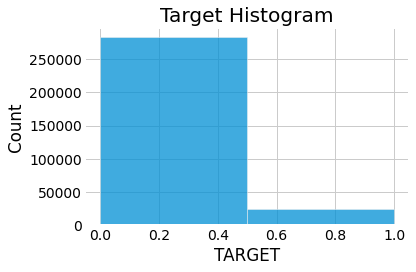

In [298]:
sns.histplot(y, bins=2).set(title="Target Histogram")
save_fig("target_distribution")
plt.show()

In [299]:
n_pos = (y == 1).sum()
n_neg = (y == 0).sum()
n_all = n_pos + n_neg
print("Percentage of data for class 0: {:.2%}".format(n_neg/n_all))
print("Percentage of data for class 1: {:.2%}".format(n_pos/n_all))

Percentage of data for class 0: 91.93%
Percentage of data for class 1: 8.07%


**The dataset is severly imbalanced.** Using a data augmentation technique like SMOTE (Synthetic Minority Oversampling Technique) may significantly improve the model performance.

### Attribute types

In [8]:
df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Some attributes have an object type, so they may hold any kind of Python object. However, since we loaded this data from a CSV file, they must be text attributes. Let's check if they are categorical attributes, meaning the number of possible values for each attribute is limited.

In [258]:
app_train.describe(include=np.object).T

,count,unique,top,freq
NAME_CONTRACT_TYPE,307511,2,Cash loans,278232
CODE_GENDER,307511,3,F,202448
FLAG_OWN_CAR,307511,2,N,202924
FLAG_OWN_REALTY,307511,2,Y,213312
NAME_TYPE_SUITE,306219,7,Unaccompanied,248526
NAME_INCOME_TYPE,307511,8,Working,158774
NAME_EDUCATION_TYPE,307511,5,Secondary / secondary special,218391
NAME_FAMILY_STATUS,307511,6,Married,196432
NAME_HOUSING_TYPE,307511,6,House / apartment,272868
OCCUPATION_TYPE,211120,18,Laborers,55186


Values are repetitive, and so may be seen as categories. Text attributes are categorical attributes, and so need to be encoded with an ordinal or one-hot encoder.

Moreover, we may have ordinal or even binary attributes among the numerical ones. If that is the case, they must be treated differently than other numerical attributes.  
Let's check binary attributes first

In [339]:
bin_att = [c for c in app_train.select_dtypes(['int', 'float'])
           if not app_train[c].nunique() > 2]
print(len(bin_att))
bin_att

33


['TARGET',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

The dataset includes many flag attributes, these attributes can take only two value "0" and "1". Scaling data, such as removing the mean value, would destroy the data structure. It would be better to let these features untouched.

Let's now analyse the ordinal features. we will condider as ordinal attributes any attribute with no more than 20 unique values.

In [340]:
ord_att = [c for c in app_train.select_dtypes(['int', 'float'])
           if not app_train[c].nunique() < 3
           and not app_train[c].nunique() > 20]
print(len(ord_att))
ord_att

10


['CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_QRT']

In [341]:
for c in ord_att:
    print(app_train[c].value_counts())

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
10         2
12         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64
2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
16.0         2
14.0         2
20.0         2
12.0         2
15.0         1
11.0         1
13.0         1
Name: CNT_FAM_MEMBERS, dtype: int64
2    226984
3     48330
1     32197
Name: REGION_RATING_CLIENT, dtype: int64
2    229484
3     43860
1     34167
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64
0.0     271324
1.0      28328
2.0       5323
3.0       1192
4.0        253
5.0         56
6.0         11
8.0          1
7.0          1
34.0         1
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: int64
0.0     280721
1.0      21841
2.0       3170
3.0        598
4.0        135
5.0         20
6.0          3
7.0          1
24.0 

Few things might be noticed:

1. three features have supicious instances:
    - `DEF_30_CNT_SOCIAL_CIRCLE`
    - `DEF_60_CNT_SOCIAL_CIRCLE`
    - `AMT_REQ_CREDIT_BUREAU_QRT`     
2. The following features have sparse data
    - `CNT_CHILDREN`
    - `DEF_30_CNT_SOCIAL_CIRCLE`
    - `DEF_60_CNT_SOCIAL_CIRCLE`
    - `AMT_REQ_CREDIT_BUREAU_HOUR`
    - `AMT_REQ_CREDIT_BUREAU_DAY`
    - `AMT_REQ_CREDIT_BUREAU_WEEK` 
    - `AMT_REQ_CREDIT_BUREAU_QRT`   
3. two features are rating with only 3 possible values: 1, 2 and 3
    - `REGION_RATING_CLIENT`  
    - `REGION_RATING_CLIENT_W_CITY`

For point 1), all instances with a value above 10 for the listed features will be filled with not an number (`np.nan`).  
For the features listed in the point 2), we will not apply the common `StandardScaler` but rather the `MaxAbsScaler` to preserve the sparseness structure in the data.  
Features listed in the point 3) will be kept entouched.

### Missing Values

Let's create a function to get the percentage of missing values for each attribute.

In [301]:
def missing_values_table(df):
    """Function to calculate missing values by column."""
    
    # Total missing values
    mis_val = df.isnull().sum()
        
    # Percentage of missing values
    mis_val_percent = (df.isnull().sum() / len(df) * 100).round(1)
        
    # Make a table with the results and
    # sorting the table by percentage of missing descending
    mis_val_table = (pd.concat([mis_val, mis_val_percent], axis=1)
                       .rename(columns={0: 'Missing Values',
                                        1: '% of Total Values'})
                       .query('`Missing Values` != 0')
                       .sort_values('% of Total Values', ascending=False))
        
    # Print some summary information
    print("The selected dataframe has {} columns.".format(df.shape[1]))
    print("There are {} columns that have missing values.".format(len(mis_val_table)))
    # Return the dataframe with missing information
    return mis_val_table

In [302]:
# Missing values statistics
missing_values = missing_values_table(df)
missing_values.head(10)

The selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
FONDKAPREMONT_MODE,210295,68.4


In [303]:
missing_values.tail(10)

,Missing Values,% of Total Values
NAME_TYPE_SUITE,1292,0.4
DEF_30_CNT_SOCIAL_CIRCLE,1021,0.3
OBS_60_CNT_SOCIAL_CIRCLE,1021,0.3
DEF_60_CNT_SOCIAL_CIRCLE,1021,0.3
OBS_30_CNT_SOCIAL_CIRCLE,1021,0.3
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
DAYS_LAST_PHONE_CHANGE,1,0.0
CNT_FAM_MEMBERS,2,0.0
AMT_ANNUITY,12,0.0


As we can see, most of features have missing values. However, apart for a few exceptions, Machine Learning algorithms cannot run with missing values. We will see how to fix them in the next section : *Prepare the data*.

### Anomalies

After missing valules, the most common problem is anomalies within data. A good way to support anomalies quantitatively is by looking at the statistics of an attibute.

In [304]:
df.describe().T.iloc[:10].round(2)

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.52,102790.18,100002.0,189145.50,278202.00,367142.50,4.562550e+05
TARGET,307511.0,0.08,0.27,0.0,0.00,0.00,0.00,1.000000e+00
CNT_CHILDREN,307511.0,0.42,0.72,0.0,0.00,0.00,1.00,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.92,237123.15,25650.0,112500.00,147150.00,202500.00,1.170000e+08
AMT_CREDIT,307511.0,599026.00,402490.78,45000.0,270000.00,513531.00,808650.00,4.050000e+06
AMT_ANNUITY,307499.0,27108.57,14493.74,1615.5,16524.00,24903.00,34596.00,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.21,369446.46,40500.0,238500.00,450000.00,679500.00,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.02,0.01,0.0,0.01,0.02,0.03,7.000000e-02
DAYS_BIRTH,307511.0,-16037.00,4363.99,-25229.0,-19682.00,-15750.00,-12413.00,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.05,141275.77,-17912.0,-2760.00,-1213.00,-289.00,3.652430e+05


The numbers for the `DAYS_BIRTH` feature are all negative, certainly because they ar recorded relative to the current loan application. Let's see these stats in years.

In [305]:
(df['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look good, one cannot say as much for the attibute just after : `DAYS_EMPLOYED`.

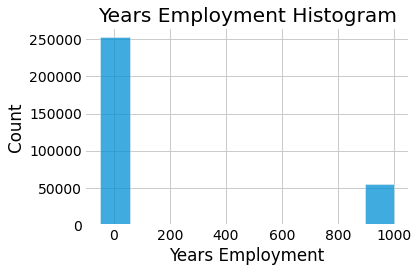

In [306]:
ax = sns.histplot(df['DAYS_EMPLOYED']/365, bins=10)
ax.set(xlabel='Years Employment',
       title='Years Employment Histogram')
save_fig("Years_Employment_distribution")
plt.show()

That does not look right, many values are about 1000 years! Let's subset the anomalous clients and see if they tend to have higher (or lower) rates of default than the rest of the clients.

In [311]:
anom = df[df['DAYS_EMPLOYED'] > 36500]
non_anom = df[df['DAYS_EMPLOYED'] <= 36500]
print(f"The non-anomalies default on {non_anom['TARGET'].mean():.1%} of loans")
print(f"The anomalies default on {anom['TARGET'].mean():.1%} of loans")
print(f"There are {len(anom)} anomalous days of employment")

The non-anomalies default on 8.7% of loans
The anomalies default on 5.4% of loans
There are 55374 anomalous days of employment


It turns out that the anomalies have a lower rate of default and so may have some importance. Let's create a new boolean attribute indicating whether or not the DAYS_EMPLOYED value is anomalous. After that, we will set the anomalies to not a number (`np.nan`).

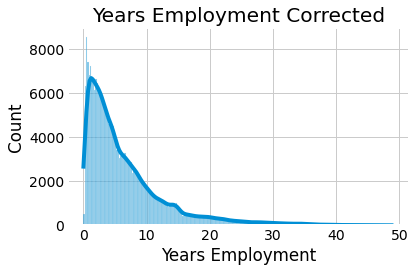

In [312]:
df = (df.assign(DAYS_EMPLOYED_ANOM=lambda x: x.DAYS_EMPLOYED > 36500)
        .assign(DAYS_EMPLOYED_ANOM=lambda x: x.DAYS_EMPLOYED_ANOM.astype(int))
        .assign(DAYS_EMPLOYED=lambda x: x.DAYS_EMPLOYED.where(x.DAYS_EMPLOYED<=36500, np.nan)))

ax = sns.histplot(-df['DAYS_EMPLOYED']/365, kde=True)
ax.set(xlabel='Years Employment',
       title='Years Employment Corrected')
save_fig('Years_Employment_distribution_corr')
plt.show()

The distribution looks to be much more in line with what we could expect.
Another feature looks suspiscious: `AMT_INCOME_TOTAL`.  
Let's see the statistics.

In [313]:
df['AMT_INCOME_TOTAL'].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

The maximum value is above 100,000,000, it is enormous! If it was true, then we can imagine that with such high income, the client did not have any problem to repay the loan.

In [315]:
(df.query('AMT_INCOME_TOTAL > 100_000_000')
   .loc[:, ['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']])

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT
12840,1,117000000.0,562491.0


 It does not look right, the credit amount is very low compare the income, but this client was in default. It is hard to believe. Let's see if we can find other clients like that. 

In [318]:
(df.query('AMT_INCOME_TOTAL > 1_000_000 & TARGET == 1')
   .loc[:, ['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']])

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT
12840,1,117000000.0,562491.0
38271,1,1125000.0,1006920.0
41725,1,1890000.0,781920.0
102626,1,1305000.0,1339884.0
151018,1,1080000.0,371245.5
167656,1,1575000.0,553806.0
173663,1,1350000.0,491211.0
196106,1,1350000.0,2517300.0
234728,1,1350000.0,576072.0
234861,1,1260000.0,1097491.5


It looks ok, the other clients with large income in default contrated a credit quite high compare to their income.  
We will set the first client value to not a number.

### Correlations

Now that we have dealt with the missing values and the outliers let's continue the exploratory data analysis with correlations. A good way to better understand the data is to look at how each attribute correlates with the target by using the `corr()` dataframe method.

In [26]:
# Find correlations with the target and sort
correlations = df.corr()['TARGET'].sort_values(ascending=False)

# Display correlations
print('Most Positive Correlations:\n', correlations.head(10))
print('\nMost Negative Correlations:\n', correlations.tail(10))

Most Positive Correlations:
 TARGET                         1.000000
DAYS_BIRTH                     0.078239
DAYS_EMPLOYED                  0.074958
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
Name: TARGET, dtype: float64

Most Negative Correlations:
 ELEVATORS_AVG                -0.034199
REGION_POPULATION_RELATIVE   -0.037227
AMT_GOODS_PRICE              -0.039645
FLOORSMAX_MODE               -0.043226
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_AVG                -0.044003
DAYS_EMPLOYED_ANOM           -0.045987
EXT_SOURCE_1                 -0.155317
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_3                 -0.178919
Name: TARGET, dtype: float64


All coefficients are close to 0, meaning there are no strong linear correlations with the target. However, we can notice that:
- as the client gets older, he is less likely to default on his loan.
- Longer the client started his current job, lower is the probability do default
- as the client gets a higher score from external data source (EXT_SOURCE_1 to 3), he is less likely to default on his loan.

Let's continue the analysis with the target and the five attributs with the highest correlation:
- DAYS_BIRTH
- DAYS_EMPLOYED
- EXT_SOURCE_1
- EXT_SOURCE_2
- EXT_SOURCE_3

We are using a heatmap to show the correlations of these features with the target and with each other.

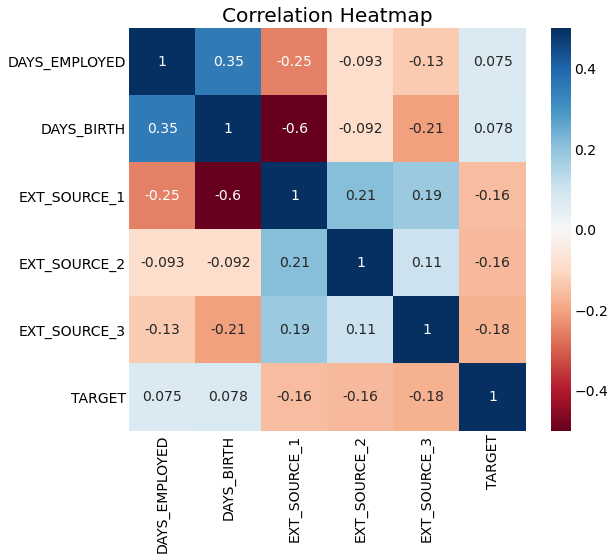

In [27]:
# Extract the EXT_SOURCE variables and show correlations
ext_att = list(correlations.abs().sort_values().tail(6).index)
ext_data_corrs = df[ext_att].corr()

# Heatmap of correlations
plt.figure(figsize = (9, 8))
sns.heatmap(ext_data_corrs, cmap='RdBu', annot = True,
            vmin=-0.5, vmax=0.5)
plt.title('Correlation Heatmap')
save_fig('Correlation_Heatmap')

We can see a strong negative correlation between `DAYS_BIRTH` and `EXT_SOURCE_1` indicating that the former maybe one of the factors used to compute this score.

Let's show a pairplot to finalize the correlation analysis.

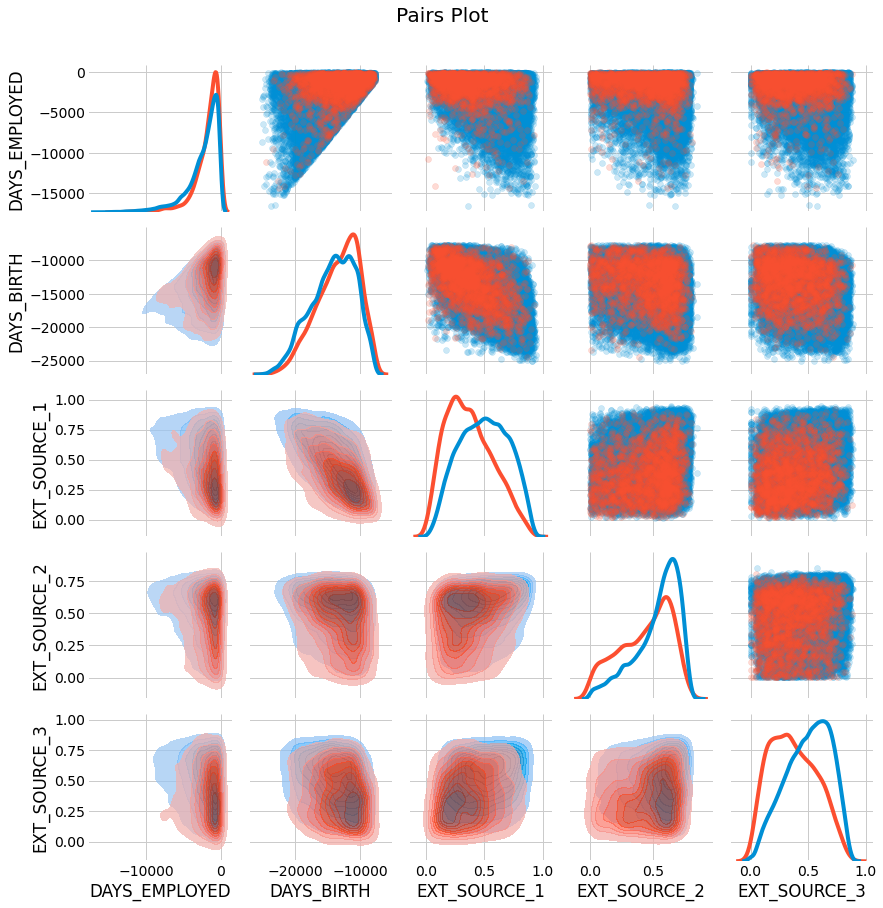

In [28]:
# Create the pairgrid object
# Drop na values and limit to the first 100,000 rows
grid = sns.PairGrid(data=df[ext_att].dropna().loc[:100_000, :],
                    diag_sharey=False, hue='TARGET')
grid.map_upper(plt.scatter, alpha=0.2)
grid.map_diag(sns.kdeplot, common_norm=False)
grid.map_lower(sns.kdeplot, common_norm=False, shade=True, alpha=.7)
plt.suptitle('Pairs Plot', size='x-large', y=1.01)
save_fig('Pairs Plot')
plt.show()

There are few things we can notice:
1. The attributes `DAYS_EMPLOYED`and `EXT_SOURCE_2` have a *tail-heavy* histogram, they extend much farther to the left of the median than to the right.
2. `EXT_SOURCE_1` and `EXT_SOURCE_3` display the biggest difference between the values of the target. These features have clearly some relationship to the likelihood of an applicant to repay a loan.

### Feature engineering

#### Basic transformations of features

As said above, the attributes `DAYS_EMPLOYED`and `EXT_SOURCE_2` have a negative skewness. This may make it a bit harder for some Machine Learning algorithms to detect patterns, Let's try to transform them.  
If a positive skewness can be easily corrected by using a log or a square root transformation it is a different story for negative ones. In that case it is better to reflect the data to get a positive skewness before transforming the data. We use the equation bolow to get reflected data:
$$X_{reflected} = 1 + X_{max} - X$$


In [29]:
#reflect the data
def transf_neg_skew_data(data, log=True):
    """Function to transform data with a negative skewness.
    The following workflow is apply:
    1. Reflect the data
    2. Apply the log or the square root on the data reflected
    -----------
    Parameters:
    data: DataFrame
    the pandas object holding the data
    log: bool, default False
    If True use the log transformation otherwise use the square root
    """
    if log:
        return (data.pipe(lambda x: 1 + x.max() - x)
                    .pipe(np.log)
                )
    else:
        return (data.pipe(lambda x: 1 + x.max() - x)
                    .pipe(np.sqrt)
                )

In [30]:
att_to_transf = ['DAYS_EMPLOYED', 'EXT_SOURCE_2']
new_names = [col + "_LOG" for col in att_to_transf]

print("With no transformation:\n",
      df[att_to_transf].skew())
for log in [True, False]:
    print("log = {}:\n".format(log),
          transf_neg_skew_data(df[att_to_transf], log).skew())

With no transformation:
 DAYS_EMPLOYED   -1.968316
EXT_SOURCE_2    -0.793576
dtype: float64
log = True:
 DAYS_EMPLOYED   -0.438516
EXT_SOURCE_2     0.573363
dtype: float64
log = False:
 DAYS_EMPLOYED    0.785716
EXT_SOURCE_2     0.682840
dtype: float64


We get better results with the log transformation.

#### Polynomial features

As seen previously, the correlation coefficients (also called Pearson's r) are quite low. That means if there are some relationship between the features and the target, then this one is not linear. We can easily make this relationship more *linear* by using the *Polynomial Features* method. This construction method creates features that are powers of existing features as well as interaction terms between the latters.

In the following code, we create polynomial features using only the most promising features meaning the five studied in the previous section.

In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
                                  
# Need to impute missing values
imputer = SimpleImputer(strategy = 'median')
X = imputer.fit_transform(df[ext_att].drop('TARGET', axis=1))
    
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)

# Transform the features
X_tr = poly_transformer.fit_transform(X)

# Create a dataframe of the features
poly_features = pd.DataFrame(X_tr, 
                             columns=poly_transformer.get_feature_names(ext_att))
poly_features['TARGET'] = df['TARGET']

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(5))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3   -0.193939
EXT_SOURCE_1 EXT_SOURCE_2   -0.166625
EXT_SOURCE_1 EXT_SOURCE_3   -0.164065
EXT_SOURCE_2                -0.160295
EXT_SOURCE_3                -0.155892
Name: TARGET, dtype: float64
DAYS_EMPLOYED EXT_SOURCE_3    0.095669
DAYS_BIRTH EXT_SOURCE_1       0.104882
DAYS_BIRTH EXT_SOURCE_3       0.150109
DAYS_BIRTH EXT_SOURCE_2       0.156873
TARGET                        1.000000
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.

#### Domain knowledge Features

Here I'm going to use five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features?scriptVersionId=6025993) by Aguiar:

- `DAYS_EMPLOYED_PERC`: the percentage of the days employed relative to the client's age
- `CREDIT_INCOME_PERC`: the percentage of the credit amount relative to a client's income
- `INCOME_PER_PERSON`: the client's income relative to the size of the client's family
- `ANNUITY_INCOME_PERC`: the percentage of the loan annuity relative to a client's income
- `CREDIT_TERM`: the length of the payment in years


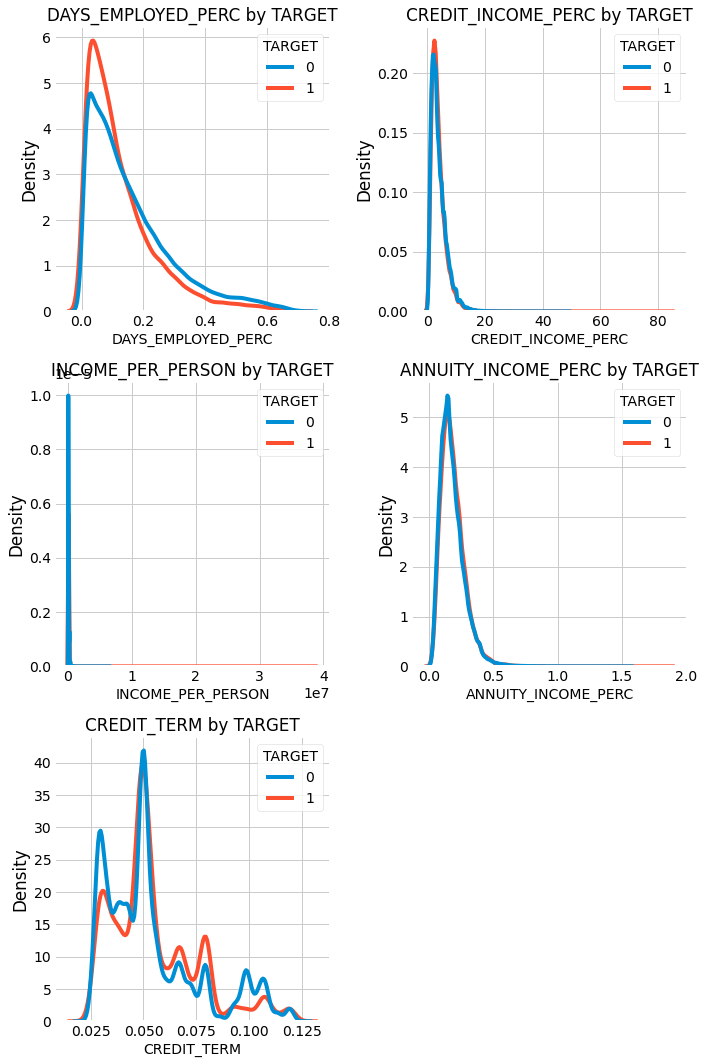

In [32]:
domain_att = ['DAYS_EMPLOYED_PERC', 
              'CREDIT_INCOME_PERC',
              'INCOME_PER_PERSON',
              'ANNUITY_INCOME_PERC',
              'CREDIT_TERM']

df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['CREDIT_INCOME_PERC'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL'] 
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

# Visualize New Features
size = 10
n_row = (len(domain_att)+1) // 2
plt.figure(figsize=(size, n_row*size/2))
for i, att in enumerate(domain_att):
    plt.subplot(3, 2, i+1)
    sns.kdeplot(data=df, x=att, hue='TARGET', common_norm=False)
    plt.title("{} by TARGET".format(att), fontsize='large')
    plt.xlabel(att, fontsize='medium')
save_fig('domain_attibutes_distributions')
plt.tight_layout()
plt.show()

In [33]:
# Find the correlations with the target
domain_corrs = df[domain_att + ['TARGET']].corr()['TARGET'].sort_values()

# Display correlations
domain_corrs

DAYS_EMPLOYED_PERC    -0.067955
CREDIT_INCOME_PERC    -0.007727
INCOME_PER_PERSON     -0.006571
CREDIT_TERM            0.012704
ANNUITY_INCOME_PERC    0.014265
TARGET                 1.000000
Name: TARGET, dtype: float64

The Person's correlation factors are pretty low, it is hard to say whether these new features will be useful or not. This will be tested in the fine-tuning section.

## Prepare the data

### Data cleaning

#### Fix or remove outliers

We saw during the Exploratory Data Analysis that the `DAYS_EMPLOYED` attribute had to be corrected.  
- Add a boolean column indicating if `DAYS_EMPLOYED` > 36,500 (100 years)
- Set anomalies to a missing value

Let's write a function to realize all these transformations.

In [360]:
def fix_outliers(X):
    """Function to fix anomalies for the following features:
    - DAYS_EMPLOYED
    -----------
    Parameters:
    X: dataframe-like
        The input samples
    """
    return (X.assign(DAYS_EMPLOYED_ANOM=lambda x: x['DAYS_EMPLOYED'] > 36500)
             .assign(DAYS_EMPLOYED_ANOM=lambda x: x['DAYS_EMPLOYED_ANOM'].astype(int))
             .assign(DAYS_EMPLOYED=lambda x: \
                     x['DAYS_EMPLOYED'].where(x['DAYS_EMPLOYED']<=36500, np.nan))
             .assign(DEF_30_CNT_SOCIAL_CIRCLE=lambda x: \
                     x['DEF_30_CNT_SOCIAL_CIRCLE'].where(x['DEF_30_CNT_SOCIAL_CIRCLE']>10,
                                                           np.nan))
             .assign(DEF_60_CNT_SOCIAL_CIRCLE=lambda x: \
                     x['DEF_60_CNT_SOCIAL_CIRCLE'].where(x['DEF_60_CNT_SOCIAL_CIRCLE']>10,
                                                         np.nan))
             .assign(AMT_REQ_CREDIT_BUREAU_QRT=lambda x: \
                     x['AMT_REQ_CREDIT_BUREAU_QRT'].where(x['AMT_REQ_CREDIT_BUREAU_QRT']>10,
                                                          np.nan))
             .assign(AMT_INCOME_TOTAL=lambda x: \
                     x['AMT_INCOME_TOTAL'].where(x['AMT_INCOME_TOTAL']>100_000_000,
                                                 np.nan)))

#### Fill in missing Data

Let's create a function to handle missing data.  
First, all attributes with a percentage of missing values higher than a given threhold ($30\%$ by default) will be dropped, then we will impute missing values:
- Categorical features are imputed with the most frequent value.
- Ordinal features are imputed with the most frequent value.
- Numerical features are imputed using the strategy.

Is considered as ordinal feature, any integer column with a number of unique values inferior to a parameter named *ord_threshold*.

In [389]:
def handle_missing_data(X, na_threshold=.3, ord_threshold=5, strategy='mean'):
    """Function to handle missing data.
    The following workflow is apply:
    1) Filter data by dropping all attributes
    with a missing value ratio above na_threshold
    2) Impute data:
        - Categorical features are imputed with the most frequent value.
        - Ordinal features are imputed with the most frequent value.
        - Numerical features are imputed using the strategy.
    -----------
    Parameters:
    X: dataframe-like
        The input samples
    na_threshold: float, default=0.3
        Control the features to drop
    ord_threshold: int, default=5
        Is considered as ordinal feature any integer column with
        a number of unique values inferior to ord_threshold.  
    strategy: String, optional (default="mean")
        The imputation strategy.
        - If "mean", then replace missing values using the mean along the axis
        - If "median", then replace missing values using the median along the axis
    """
    if na_threshold > 1:
        na_threshold /= 100
    # filter data
    mask = X.isna().sum()/len(X) > na_threshold
    att_to_del = list(X.loc[:, mask])
    X = X.drop(att_to_del, axis=1)
    # impute categorical and ordinal features
    cat_att = list(X.select_dtypes('object'))
    ord_att = [c for c in list(X.select_dtypes(['int', 'float']))
               if X[c].nunique() < ord_threshold]
    mf_att = cat_att + ord_att
    mf_val = dict(zip(mf_att, X[mf_att].value_counts().index[0]))
    X_mf = X[mf_att].fillna(mf_val)
    # impute num data
    num_att = [c for c in list(X)
               if c not in mf_att]
    if strategy == 'median':
        X_num = X[num_att].fillna(X[num_att].median())
    else:
        X_num = X[num_att].fillna(X[num_att].mean())
    return pd.concat([X_mf, X_num], axis=1)

#### Cleaning pipeline

In [390]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

cleaning_pipeline = Pipeline([
                    ('outlier_cleaner', FunctionTransformer(fix_outliers)),
                    ('imputer', FunctionTransformer(handle_missing_data)),
                    ])

In [391]:
X = cleaning_pipeline.fit_transform(app_train)

In [326]:
app_train.CNT_FAM_MEMBERS.value_counts()

2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
16.0         2
14.0         2
20.0         2
12.0         2
15.0         1
11.0         1
13.0         1
Name: CNT_FAM_MEMBERS, dtype: int64

In [329]:
app_train.CNT_FAM_MEMBERS.dtype

dtype('float64')

In [327]:
app_train.CNT_CHILDREN.value_counts()

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
10         2
12         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64

### Encoding Categorical Variables

To encode the categorical attributes we will implement the following strategy:
- Attributes with only two categories are encoded as an integer array (`OrdinalEncoder`)
- Attributes with more than two categories encoded as a one-hot numeric array (`OneHotEncoder`)

In [147]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

cat_att = list(X.select_dtypes('object'))
onehot_att = [c for c in cat_att
              if X[c].nunique() > 2]
ord_att = [c for c in cat_att
           if c not in onehot_att]

cat_encoding = ColumnTransformer([
               ('ord_encoding', OrdinalEncoder(), ord_att),
               ('onehot_encoding', OneHotEncoder(), onehot_att),
               ])

### Custom transformers

In [159]:
# Add polynomial features
def add_polynomial_att(X, degree=2):
    """Generate polynomial and interaction features.
    Only the five most TARGET correlated features are taken into account.
    -----------
    Parameters:
    X: dataframe-like
        The input samples
    degree: int, default=2
        The degree of the polynomial features
    """
    poly_att = ['EXT_SOURCE_2',
                'EXT_SOURCE_3',
                'DAYS_BIRTH',
                'DAYS_EMPLOYED',
                'REGION_RATING_CLIENT_W_CITY']
    # create the polynomial object with specified degree
    poly_transformer = PolynomialFeatures(degree=degree, include_bias=False)
    # get the most target correlated features
    X = data[poly_att]
    # Transform the features
    X_tr = poly_transformer.fit_transform(X)
    # Create a DataFrame of the features
    cols = poly_transformer.get_feature_names(poly_att)
    df_poly = pd.DataFrame(X_tr, columns=cols)
    return pd.concat([data, df_poly], axis=1)

In [148]:
# Add domain knowledge features
def add_domain_att(X):
    """Function to add five domain Knowledge attributes:
    - DAYS_EMPLOYED_PERC: the percentage of the days employed relative to the client's age
    - CREDIT_INCOME_PERC: the percentage of the credit amount relative to a client's income
    - INCOME_PER_PERSON: the client's income relative to the size of the client's family
    - ANNUITY_INCOME_PERC: the percentage of the loan annuity relative to a client's income
    - CREDIT_TERM: the length of the payment in years
    -----------
    Parameters:
    X: dataframe-like
        The input samples
    """
    att_used = ['DAYS_EMPLOYED', 'DAYS_BIRTH', 'CNT_FAM_MEMBERS',
                'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY']
    return (data.loc[:, att_used]
                .assign(DAYS_EMPLOYED_PERC= lambda df:
                        df['DAYS_EMPLOYED']/df['DAYS_BIRTH'])
                .assign(CREDIT_INCOME_PERC= lambda df:
                        df['AMT_CREDIT']/df['AMT_INCOME_TOTAL'])
                .assign(INCOME_PER_PERSON= lambda df:
                        df['AMT_INCOME_TOTAL']/df['CNT_FAM_MEMBERS'])
                .assign(ANNUITY_INCOME_PERC= lambda df:
                        df['AMT_ANNUITY']/df['AMT_INCOME_TOTAL'])
                .assign(CREDIT_TERM= lambda df:
                        df['AMT_ANNUITY']/df['AMT_CREDIT']))

In [228]:
# Add Basic transformation
def tr_skew_data(X, log=True, threshold=1.):
    """Transform data with an abs(skewness) > threshold
    For data with negative skewness, data are reflected first.
    -----------
    Parameters:
    X: dataframe-like
        The input samples
    log: bool, default False
        If True use the log transformation otherwise use the square root
    threshold: float, default=1.0
        Control the features to transform
    """
    neg_skew_att = list(X.skew().index[X.skew() < -threshold])
    pos_skew_att = list(X.skew().index[X.skew() > threshold])
    if log:
        dic_neg = dict(zip(neg_skew_att,
                           [np.log(1 + X[c].max() - X[c])
                            for c in neg_skew_att]))              
        dic_pos = dict(zip(pos_skew_att,
                           [np.log(1 + X[c])
                            for c in pos_skew_att]))
        return (X.assign(**dic_neg)
                 .assign(**dic_pos))
    else:
        dic_neg = dict(zip(neg_skew_att,
                           [np.sqrt(1 + X[c].max() - X[c])
                            for c in neg_skew_att]))               
        dic_pos = dict(zip(pos_skew_att,
                           [np.sqrt(1+ X[c])
                            for c in pos_skew_att]))
        return (X.assign(**dic_neg)
                 .assign(**dic_pos))

In [235]:
X = cleaning_pipeline.fit_transform(app_train.drop('TARGET', axis=1))

In [241]:
X.select_dtypes('int').shape

(307511, 40)

In [247]:
X.select_dtypes('int').shape

(307511, 40)

In [257]:
ord_att = [c for c in X.select_dtypes('int')
           if not X[c].nunique() > 2]
print(len(ord_att))
ord_att

33


['FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'DAYS_EMPLOYED_ANOM']

In [236]:
all_att = list(X.columns)
num_att = [c for c in all_att
           if c not in cat_att]
X_tr = tr_skew_data(X[num_att])

In [237]:
print(X.skew().sort_values().head(10))
print(X.skew().sort_values().tail(10))

FLAG_MOBIL               -554.536744
FLAG_CONT_MOBILE          -23.081172
DAYS_EMPLOYED              -2.173733
FLAG_EMP_PHONE             -1.664886
FLAG_DOCUMENT_3            -0.925725
EXT_SOURCE_2               -0.794429
DAYS_LAST_PHONE_CHANGE     -0.713607
DAYS_REGISTRATION          -0.590872
EXT_SOURCE_3               -0.457213
DAYS_BIRTH                 -0.115673
dtype: float64
FLAG_DOCUMENT_20              44.364897
FLAG_DOCUMENT_21              54.612939
FLAG_DOCUMENT_17              61.214140
FLAG_DOCUMENT_7               72.174108
FLAG_DOCUMENT_4              110.894364
AMT_REQ_CREDIT_BUREAU_QRT    144.472229
FLAG_DOCUMENT_2              153.791817
FLAG_DOCUMENT_10             209.589054
AMT_INCOME_TOTAL             391.559654
FLAG_DOCUMENT_12             392.114779
dtype: float64


In [239]:
X.FLAG_MOBIL.describe()

count    307511.000000
mean          0.999997
std           0.001803
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: FLAG_MOBIL, dtype: float64

In [238]:
print(X_tr.skew().sort_values().head(10))
print(X_tr.skew().sort_values().tail(10))

FLAG_DOCUMENT_3          -0.925725
EXT_SOURCE_2             -0.794429
DAYS_LAST_PHONE_CHANGE   -0.713607
DAYS_EMPLOYED            -0.701874
DAYS_REGISTRATION        -0.590872
EXT_SOURCE_3             -0.457213
AMT_ANNUITY              -0.345696
AMT_CREDIT               -0.338818
AMT_GOODS_PRICE          -0.293898
DAYS_BIRTH               -0.115673
dtype: float64
FLAG_DOCUMENT_19     40.956134
FLAG_DOCUMENT_20     44.364897
FLAG_DOCUMENT_21     54.612939
FLAG_DOCUMENT_17     61.214140
FLAG_DOCUMENT_7      72.174108
FLAG_DOCUMENT_4     110.894364
FLAG_DOCUMENT_2     153.791817
FLAG_DOCUMENT_10    209.589054
FLAG_DOCUMENT_12    392.114779
FLAG_MOBIL          554.536744
dtype: float64


In [226]:
X['FLAG_DOCUMENT_18'].describe()

count    307511.000000
mean          0.008130
std           0.089798
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: FLAG_DOCUMENT_18, dtype: float64

In [227]:
X['FLAG_DOCUMENT_18'].skew()

10.955079518130958

In [218]:
feat_eng_pipeline = Pipeline([
                    ('poly_att_adder', FunctionTransformer(add_polynomial_att)),
                    ('dom_att_adder', FunctionTransformer(add_domain_att)),
                    ('transformer', FunctionTransformer(tr_skew_data)),
                    ])

### Transformation Pipelines

In [219]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler 

all_att = list(app_train.drop('TARGET', axis=1).columns)
num_att = [c for c in all_att
           if c not in cat_att
           and X[c].nunique() > 3
           and c != 'CNT_CHILDREN']

full_pipeline = ColumnTransformer([
                ('cleaner', cleaning_pipeline, all_att),
                ('encoder', cat_encoding, cat_att),
                ('feat_eng', feat_eng_pipeline, num_att),
                ('maxabs_scaler', MaxAbsScaler, ['CNT_CHILDREN']),
                ('std_scaler', StandardScaler(), num_att),
                ])

## Shortlist Promising Models

### Select a Performance Measure

### Establish a performance baseline with a dummy classifier

### Train quick and dirty models and compare their performance

## Fine-Tune the System

### Use as much data as possible by merging all tables

### Feature Selection

### Data augmentation with SMOTE

### Fine-Tune the hyperparameters using cross-validation

### Try ensemble methods and select the final model